In [1]:
#Import neccessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import shap

In [2]:
#Import dataset
campus = pd.read_csv("C:/Users/yashs/OneDrive/Documents/Campus_Selection.csv")

In [ ]:
campus.info()

In [3]:
campus = campus.drop(columns = "sl_no")

In [ ]:
campus.head()

In [4]:
#Perform Frequency encoding
#Case1: Gender
frequencygen = campus['gender'].value_counts(normalize=True)
# Map gender categories to frequency values
campus['encoded_gender'] = campus['gender'].map(frequencygen)
#Case2: SSC_B
frequencySSC_p = campus['ssc_b'].value_counts(normalize=True)
#Map ssc_b categories to frequency values
campus['encoded_ssc_b'] = campus['ssc_b'].map(frequencySSC_p)
#Case3: HSC_B
frequencyhsc_b = campus['hsc_b'].value_counts(normalize=True)
#Map hsc_b categories to frequency values
campus['encoded_hsc_b'] = campus['hsc_b'].map(frequencyhsc_b)
#Case4: HSC_S
frequencyhsc_s = campus['hsc_s'].value_counts(normalize=True)
#Map hsc_s categories to frequency values
campus['encoded_hsc_s'] = campus['hsc_s'].map(frequencyhsc_s)
#Case5: DEGREE_T
frequencydegt = campus['degree_t'].value_counts(normalize=True)
#Map degree_t categories to frequency values
campus['encoded_degree_t'] = campus['degree_t'].map(frequencydegt)
#Case6: WORKEX
frequencywkex = campus['workex'].value_counts(normalize=True)
#Map workex categories to frequency values
campus['encoded_workex'] = campus['workex'].map(frequencywkex)
#Case7: SPECIALISATION
frequencyspec = campus['specialisation'].value_counts(normalize=True)
#Map specialisation categories to frequency values
campus['encoded_specialisation'] = campus['specialisation'].map(frequencyspec)

In [ ]:
campus.dtypes

In [ ]:
campus.head(10)

In [5]:
campus = campus.drop(columns = ["gender","ssc_b","hsc_b","hsc_s","degree_t","workex","specialisation"])

In [6]:
target = campus[['status']]
le = LabelEncoder()
target['encoded_status'] = le.fit_transform(target['status'])
target = target.drop(columns = "status")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
campus = campus.drop(columns =["status"])

In [8]:
#Normalization values
#Initialize the scalar
scaler = StandardScaler()
#Fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(campus), columns=campus.columns)

In [10]:
df_normalized.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,encoded_gender,encoded_ssc_b,encoded_hsc_b,encoded_hsc_s,encoded_degree_t,encoded_workex,encoded_specialisation
0,-0.028087,2.268812,-1.140102,-1.291091,-0.597647,0.739434,-1.082459,0.800763,0.633533,-1.235621,0.724446,-1.123903
1,1.113369,1.103448,1.513267,1.087157,0.687620,0.739434,0.923823,0.800763,-0.325689,-1.235621,-1.380364,0.889757
2,-0.213238,0.153313,-0.322843,0.218908,-0.769474,0.739434,0.923823,-1.248809,-3.813769,0.677512,0.724446,0.889757
3,-1.046417,-1.318339,-1.957362,-0.460592,-0.489396,0.739434,0.923823,-1.248809,-0.325689,-1.235621,0.724446,-1.123903
4,1.712332,0.668391,0.943909,1.864806,-1.164676,0.739434,0.923823,-1.248809,0.633533,0.677512,0.724446,0.889757


In [11]:
#Split the dataset into train, test and validation data
X_train, X_temp, y_train, y_temp = train_test_split(df_normalized, target, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [12]:
X_train.shape[1]

12

In [13]:
#Define ANN model
#Model1
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
#Compile the ANN
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)

In [ ]:
history1 = ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,  # Set to a higher number since early stopping may halt training early
    callbacks=[early_stopping]
)

In [ ]:
#Compute and return the test loss and accuracy without displaying output.
test_loss, test_accuracy = ann.evaluate(X_test, y_test, verbose=0)

In [ ]:
# Check if early stopping was triggered
if early_stopping.stopped_epoch > 0:
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience
else:
    best_epoch = len(history.history['loss']) - 1  # Use the last epoch as the best one

# Print the metrics
print('Training Loss', history.history['loss'][best_epoch])
print('Validation Loss', history.history['val_loss'][best_epoch])
print('Training Accuracy', history.history['accuracy'][best_epoch])
print('Validation Accuracy', history.history['val_accuracy'][best_epoch])
print('Test Accuracy', test_accuracy)
print('Epoch Stopped', best_epoch + 1)  # epochs are zero-indexed, but we report them starting from 1


In [14]:
###Hyperparameter training
#Set parameter
param_grid = {
    'activation': ['relu', 'tanh', 'sigmoid'],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_hidden': [1, 2],
    'num_neurons': [32, 64, 128],
    #'kernel_initializer': ['he_uniform', 'glorot_uniform', 'random_normal'],
    'add_dropout': [True, False]
}

In [15]:
#New model
def build_model2(hp):
    model = Sequential()
    
    # Input layer (customize input_shape as needed)
    model.add(Input(shape=(X_train.shape[1],)))

    # Number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                activation=hp.Choice('activation', ['relu', 'tanh','sigmoid']),
            )
        )
        if hp.Boolean('add_dropout'):
            model.add(Dropout(rate=0.3))
    
    # Output layer (binary classification example)
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.05])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [16]:
#Use randomsearch optimization
from keras_tuner import RandomSearch, BayesianOptimization, Hyperband

tuner = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='tuning_example'
)

# Run search (use appropriate validation split or val_data)
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from my_dir\tuning_example\tuner0.json


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Print all the best hyperparameters
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

num_layers: 2
units_0: 96
activation: tanh
add_dropout: True
learning_rate: 0.001
units_1: 192
units_2: 224


In [18]:
#Use bayesian optimization
bayesian_tuner = BayesianOptimization(
    build_model2,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =1,
    directory='bayesian_opt',
    project_name='tuning_example1'
)

# Run search (use appropriate validation split or val_data)
bayesian_tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose = 0)

# Get the best model
best_model1 = bayesian_tuner.get_best_models(num_models=1)[0]

Reloading Tuner from bayesian_opt\tuning_example1\tuner0.json


In [19]:
best_hps1 = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]
# Print all the best hyperparameters
for param in best_hps1.values:
    print(f"{param}: {best_hps1.get(param)}")

num_layers: 3
units_0: 192
activation: relu
add_dropout: True
learning_rate: 0.01
units_1: 128
units_2: 96


In [20]:
#Implement early_stopping for bayesian
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)

In [21]:
#Bayesian optimization #Model2
history = best_model1.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size =32, epochs=100, verbose=1,
                          callbacks=early_stopping)

Epoch 1/100
5/5 [==============================] - 1s 40ms/step - loss: 0.1236 - accuracy: 0.9612 - val_loss: 0.5705 - val_accuracy: 0.8372
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 0.2439 - accuracy: 0.9070 - val_loss: 0.5281 - val_accuracy: 0.8372
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.1461 - accuracy: 0.9380 - val_loss: 0.5419 - val_accuracy: 0.8372
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0976 - accuracy: 0.9690 - val_loss: 0.5432 - val_accuracy: 0.8140
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0750 - accuracy: 0.9767 - val_loss: 0.6163 - val_accuracy: 0.8140


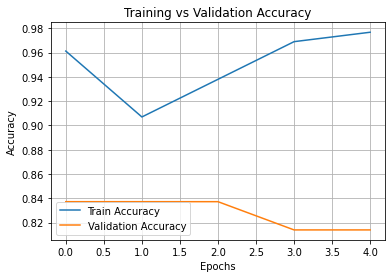

In [35]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#Early stopping with bayesian
if early_stopping.stopped_epoch > 0:
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience
else:
    best_epoch = len(history.history['loss']) - 1  # Use the last epoch as the best one

# Print the metrics
print('Training Loss', history.history['loss'][best_epoch])
print('Validation Loss', history.history['val_loss'][best_epoch])
print('Training Accuracy', history.history['accuracy'][best_epoch])
print('Validation Accuracy', history.history['val_accuracy'][best_epoch])
print('Epoch Stopped', best_epoch + 1)

Training Loss 0.24390706419944763
Validation Loss 0.5281054973602295
Training Accuracy 0.9069767594337463
Validation Accuracy 0.8372092843055725
Epoch Stopped 2


In [23]:
#Use hyperband optimization
hyperband_tuner = Hyperband(
    build_model2,
    objective='val_loss',
    max_epochs=10,
    directory='hyperband',
    project_name='tuning_example2')

# Run search (use appropriate validation split or val_data)
hyperband_tuner.search(X_train, y_train, epochs=10,validation_data=(X_val, y_val))

# Get the best model
best_model2 = hyperband_tuner.get_best_models(num_models=1)[0]

Reloading Tuner from hyperband\tuning_example2\tuner0.json


In [24]:
best_hps2 = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]
# Print all the best hyperparameters
for param in best_hps2.values:
    print(f"{param}: {best_hps2.get(param)}")

num_layers: 1
units_0: 32
activation: relu
add_dropout: False
learning_rate: 0.05
units_1: 160
units_2: 256
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [25]:
#Hyperband optimization
history2 = best_model2.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=32, epochs=100, verbose=1, callbacks=early_stopping)

Epoch 1/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0913 - accuracy: 0.9535 - val_loss: 0.5413 - val_accuracy: 0.7907
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.1031 - accuracy: 0.9767 - val_loss: 0.5271 - val_accuracy: 0.8140
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0894 - accuracy: 0.9767 - val_loss: 0.4872 - val_accuracy: 0.8605
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1630 - accuracy: 0.9457 - val_loss: 0.5518 - val_accuracy: 0.8605
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0910 - accuracy: 0.9612 - val_loss: 0.7110 - val_accuracy: 0.7907
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0799 - accuracy: 0.9767 - val_loss: 0.8374 - val_accuracy: 0.7674


In [26]:
#Early stopping with hyperband
if early_stopping.stopped_epoch > 0:
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience
else:
    best_epoch = len(history2.history['loss']) - 1  # Use the last epoch as the best one

# Print the metrics
print('Training Loss', history2.history['loss'][best_epoch])
print('Validation Loss', history2.history['val_loss'][best_epoch])
print('Training Accuracy', history2.history['accuracy'][best_epoch])
print('Validation Accuracy', history2.history['val_accuracy'][best_epoch])
print('Epoch Stopped', best_epoch + 1)

Training Loss 0.08937810361385345
Validation Loss 0.487240195274353
Training Accuracy 0.9767441749572754
Validation Accuracy 0.8604651093482971
Epoch Stopped 3


In [27]:
#Bayesian
loss, acc = best_model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

2/2 [==============================] - 0s 0s/step - loss: 0.3967 - accuracy: 0.8372
Test Accuracy: 0.84


In [28]:
loss, acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

2/2 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.8372
Test Accuracy: 0.84


In [29]:
#Hyperband
loss, acc = best_model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

2/2 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.7674
Test Accuracy: 0.77


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
#Bayesian
y_pred = best_model1.predict(X_test)

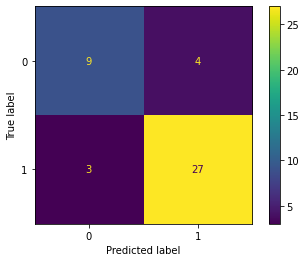

In [32]:
y_pred_classes = (y_pred > 0.5).astype(int)  # Ensure binary output for sigmoid

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

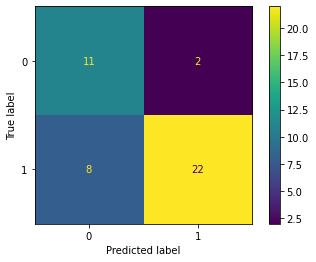

In [33]:
#Hyperband
y_pred1 = best_model2.predict(X_test)
y_pred_classes1 = (y_pred1 > 0.5).astype(int)  # Ensure binary output for sigmoid

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()